In [1]:
# trying to explain the differences in nuclear height and volume observed in edge cells

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/Others
Mon May 16 14:02:47 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from sklearn.decomposition import PCA
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)

In [5]:
dsname = "edges"
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    dsname: {
        "control": f"{path_cvapipe}/local_staging_variance_edges",
        "perturbed": f"{path_cvapipe}/local_staging_edge_cells_midpoint_expanded"
    }}

In [6]:
dsmanagers = common.setup_cvapipe_for_matched_dataset(config, datasets[dsname])

In [68]:
dfs = {}
for cond in ["control", "perturbed"]:
    df = dsmanagers[cond]["device"].load_step_manifest("preprocessing")
    df["dataset"] = cond
    dfs[cond] = df
    print(cond, dfs[cond].shape)

control (4477, 1291)
perturbed (5169, 1256)


In [69]:
dfs["shape_matched"] = dfs["control"].append(dfs["perturbed"], ignore_index=True).reset_index()

In [88]:
def get_values(feat, space, group):
    if "_PC" in feat:
        space.set_active_shape_mode(feat, True)
        sigma = space.get_active_scale()
        x = space.shape_modes[feat] / sigma
    else:
        x = space.df.loc[space.shape_modes.index, feat]
        
    valids = space.df.loc[(space.df.index.isin(space.shape_modes.index))&(space.df.dataset==group)].index
    return x[valids]

In [89]:
feats = ["MEM_shape_volume", "MEM_position_depth"] + control.get_shape_modes()
feat_names = ["Volume", "Height"] + [f"PC{i+1}" for i in range(8)]
nfs = len(feats)
scale = 1.5

(4477, 1291) (4477, 8) (3832, 8)


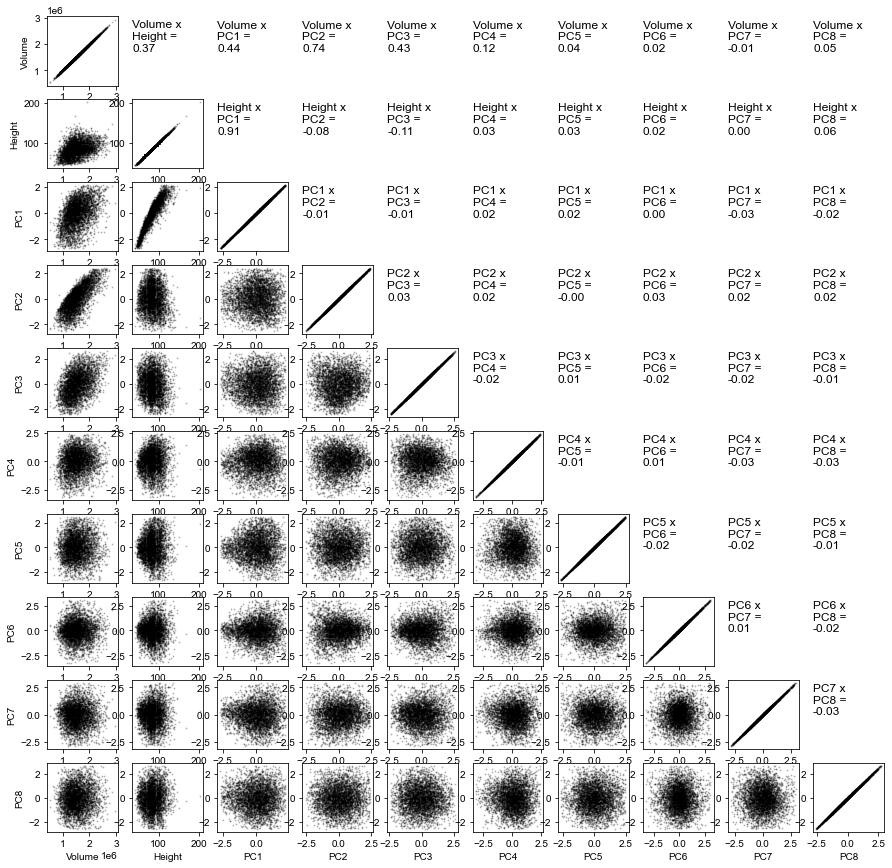

(5169, 1256) (5169, 8) (4443, 8)


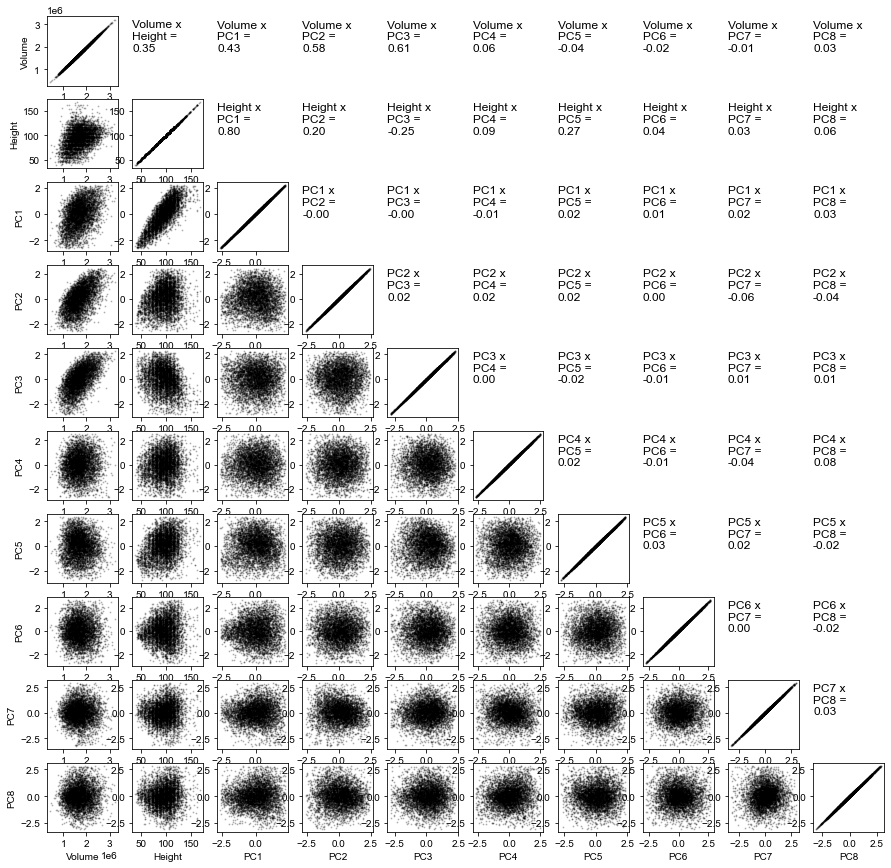

(9646, 1292) (9646, 8) (8287, 8)


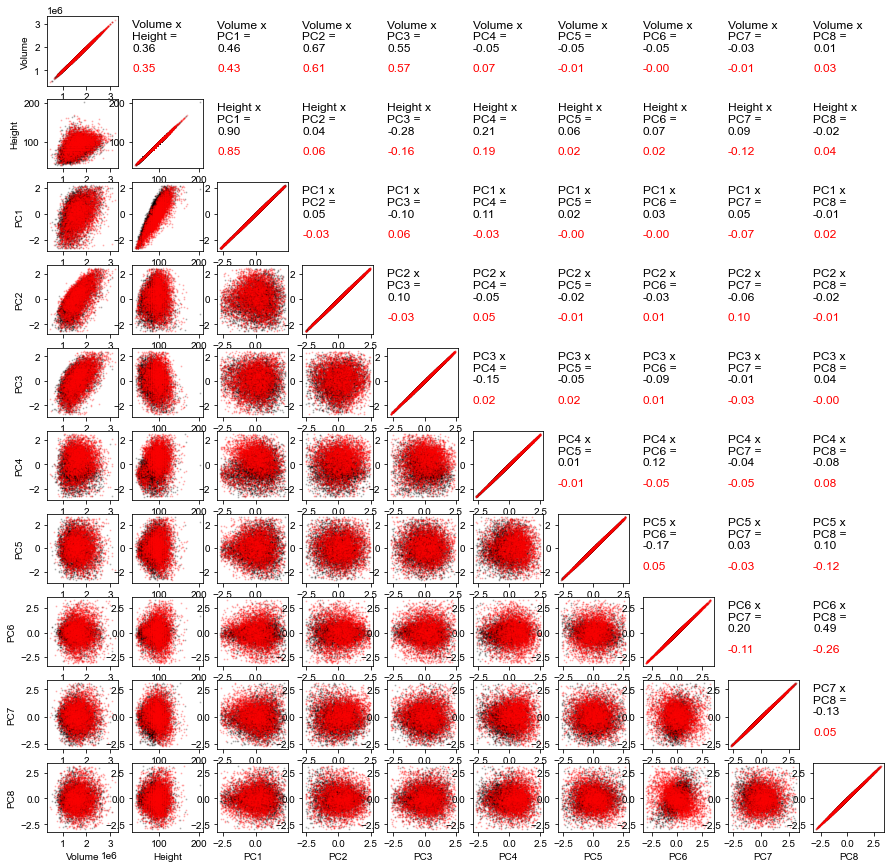

In [92]:
for ds, df in dfs.items():
    # Using control from main dataset to get 8 shape modes and 9 bins
    space = shapespace.ShapeSpace(control)
#     space.set_remove_extreme_points(False)
    space.execute(df)
    print(space.df.shape, space.axes.shape, space.shape_modes.shape)
    
    fig, axs = plt.subplots(nfs, nfs, figsize=(scale*nfs, scale*nfs))
    for (group, df_group), color in zip(df.groupby("dataset"), ["k", "r"]):
        for f1id, f1 in enumerate(feats):
            y = get_values(f1, space, group)
            for f2id, f2 in enumerate(feats):
                ax = axs[f1id, f2id]
                x = get_values(f2, space, group)
                if f2id <= f1id:
                    ax.scatter(x, y, s=1, c=color, alpha=0.2)
                    if f2id == 0:
                        ax.set_ylabel(feat_names[f1id])
                    if f1id == nfs-1:
                        ax.set_xlabel(feat_names[f2id])
                else:
                    corr = np.corrcoef(x, y)[0, 1]
                    if color == "k":
                        ax.text(0, 0.5, f"{feat_names[f1id]} x\n{feat_names[f2id]} = \n{corr:.2f}", fontsize=12, color=color)
                    else:
                        ax.text(0, 0.2, f"{corr:.2f}", fontsize=12, color=color)
                    ax.axis("off")
    plt.show()

#           PC1xH PC2xH  PC2xV PC1xPC2 HxV
# allcells, 0.92, -0.04, 0.87, -0.02, -0.02
# nonedges, 0.91, -0.08, 0.74, -0.01, -0.01
# edges,    0.80,  0.20, 0.58, -0.00, -0.00
# non-m1m2, 0.94, -0.00, 0.64, -0.01, -0.01
# m1m2,     0.94, -0.05, 0.79, -0.03, -0.03
# non-m3,   0.96, -0.03, 0.84, -0.05, -0.05 
# m3,       0.93, -0.18, 0.62, -0.04, -0.04